In [128]:
# !pip install git+https://github.com/ginihumer/segmentation-explanation-adapter.git
! python --version

Python 3.8.13


In [123]:
import segmentationadapter
from segmentationadapter import get_mask_for_class
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt

2.8.0


# 1. Load Segmentation Model

In [11]:
with tf.device("/cpu:0"):
    model = tf.keras.models.load_model("../models/mushroom_seg_model.h5")

In [12]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 384, 384, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 384, 384, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

# 2. Load and preprocess Image

In [60]:
image_path = "../data/TL2015PIC41336870.JPG"
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(384, 384))
array = tf.keras.preprocessing.image.img_to_array(img)
# We add a dimension to transform our array into a "batch"
preprocess_input = tf.keras.applications.vgg16.preprocess_input
array = preprocess_input(np.expand_dims(array, axis=0))

# 3. Generate mask that selects all pixels of a class (could also produce a custom mask)

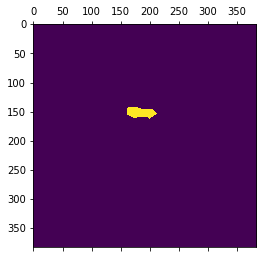

In [77]:
class_idx=2
with tf.device("/cpu:0"):
    mask = get_mask_for_class(model, array, class_idx=class_idx)
    plt.matshow(mask[0,:,:,0])

# 4. Transform the Segmentation Network to an Explainable Network that resembles the Architecture of a Classifier

In [78]:
with tf.device("/cpu:0"):
    explainable_model = segmentationadapter.get_explainable_model(model, mask=mask)
    explainable_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 384, 384, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 384, 384, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

# 5. Calculate Grad-CAM (or other explanation methods)

In [ ]:
# !pip install tf-explain

In [118]:
from tf_explain.core.grad_cam import GradCAM # this implementation of GradCAM does not use ReLU on the output to disregard negative values...

In [119]:
with tf.device("/cpu:0"):
    data = (array, None)
    explainer = GradCAM()
    grid = explainer.explain(
        data, explainable_model, class_index=class_idx, layer_name="final_conv", use_guided_grads=False, image_weight=0
    )

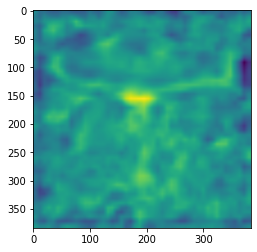

In [120]:
plt.imshow(grid)